# NLP Predict Disaster Tweet Classifier

### Notebook Description
The following notebook explores a model attempting to classify a set of tweets with the appropriate label: 1 for tweets about real disasters and 0 for tweets not about real disasters.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from funcs import *
import random
import math

/tmp/ipykernel_3429/1131998491.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Loading and Analysis

In [2]:
tweets = pd.read_csv('train.csv')
display(tweets.head(5))
number_tweets = tweets.shape[0]
print(f'{number_tweets} entries with {tweets.shape[1]} features')

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


7613 entries with 5 features


_The following cell selects 7 tweets at random and displays their text contents as well as target_

In [3]:
#checking for label imbalance
num_1 = tweets[tweets['target'] == 1]['target'].count()
num_0 = tweets[tweets['target'] == 0]['target'].count()

print('tweets labeled to describe an actual disaster: ',num_1)
print('tweets labeled NOT to describe an actual disaster: ',num_0)

tweets labeled to describe an actual disaster:  3271
tweets labeled NOT to describe an actual disaster:  4342


In [106]:
for _ in range(7):
    ix = random.randint(0,number_tweets+1)
    print('location: ',ix)
    tweet = tweets.loc[ix,'text']
    display(tweet,tweets.loc[ix,'target'])
    # sent_len_ratio = capitals_vs_sentence_len(tweet) 
    # print(sent_len_ratio)
    print()

location:  3120


'Also my iPhone charger is broken and I just electrocuted myself.'

0


location:  3305


"So all the store's fire alarms went off today at work and we had to evacuate. I was like 'OMG!! I.S.I.S. ITS HAPPENING!!!!'"

1


location:  4185


'I liked a @YouTube video from @chaboyyhd http://t.co/Yr67ugEsrm Battlefield 4 Funny Moments - Dukes of Hazard Undercover Soldier'

0


location:  967


'AUTH LOUIS VUITTON BROWN SAUMUR 35 CROSS BODY SHOULDER BAG MONOGRAM 7.23 419-3 - Full read\x89Û_ http://t.co/HCDiwE5flc http://t.co/zLvEbEoavG'

0


location:  2402


'Happy no one was hurt when #wmata train derailed. Also the express bus is so much better than metro rail http://t.co/7cEhNV3DKy @fox5newsdc'

1


location:  2603


'@DavidVitter Hi David in 2003 I saw the USA walk into a war that destroyed the lives of millions. You can prevent a repeat. #IranDeal'

1


location:  3872


'Maryland mansion fire that killed 6 caused by damaged plug under Christmas tree report says - Into the flames... http://t.co/lKJFabQzb3'

1

### Evaluating Text Features

_The following cell contains words selected to develop the model as well as words that did not prove to be useful_

In [129]:
sample_words = ["'",'report','after','evacuat','http','hurricane','earthquake','drought','flood','fire','survivor',\
               'storm','terr',':','police','crash','death','casualt','injur','war']
# ["'",'report','after','evacuation','http','hurricane','earthquake','drought','flood','fire','survivor',\
#                'storm','terr',':','police','crash','death','casualt','injur']

useless_words = ['aid','please','information','notify','authorities','body','rescue','response'\
                'civilian','escape','#news','quarantine','explosion','shoot','colli','hostage','terrorist']

In [130]:
feats = pd.DataFrame()
labels = tweets['target']

feats.loc[:, sample_words] = words_in_texts(sample_words, tweets['text'])
feats.head(1)

,',report,after,evacuat,http,hurricane,earthquake,drought,flood,fire,survivor,storm,terr,:,police,crash,death,casualt,injur,war
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


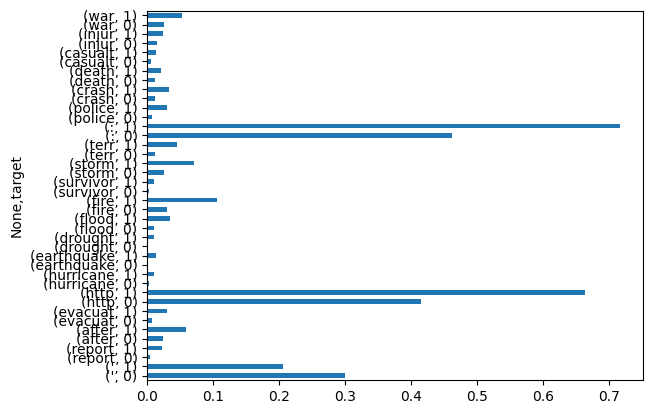

In [131]:
eda_df = feats.join(labels)
graph_comparison = pd.DataFrame(eda_df.groupby('target').mean()).unstack(0).plot.barh();

/tmp/ipykernel_3429/654379560.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(eda_df, x='target',y='email len',palette={'0':'r','1':'g'});
/home/ljones333/miniconda3/envs/chem277b/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ljones333/miniconda3/envs/chem277b/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


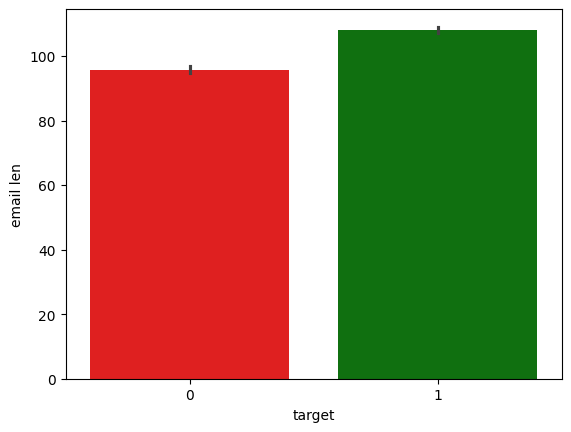

In [8]:
eda_df['email len'] = [len(tweet) for tweet in tweets['text']]
sns.barplot(eda_df, x='target',y='email len',palette={'0':'r','1':'g'});

In [9]:
sample_sentence1 = "why is my model attaining low accuracy??."
sample_sentence2 = "Model by Laura Kollmorgen seems to only attain \
an accuracy of .67 LOL...."

In [10]:
assert capitals_vs_sentence_len(sample_sentence1) == 0
assert capitals_vs_sentence_len(sample_sentence2) > 0

In [11]:
assert count_periods(sample_sentence1) == 1
assert count_periods(sample_sentence2) == 5

In [12]:
assert count_digits(sample_sentence1) == 0
assert count_digits(sample_sentence2) == 2

_The above EDA was useful in identifying features from the tweets that could contribute to our classifier model_

## Model

In [13]:
#imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [132]:
def tweet_processing(df):
    if df.ndim < 2:
        raise('Yo this df is too small')
        
    #words initially evaluated to become features
    word_features = ["'",'report','after','evacuat','http','hurricane','earthquake','drought','flood','fire','survivor',\
               'storm','terr',':','police','crash','death','casualt','injur','war']
    
    map = dict(zip(range(0,len(word_features)),word_features))
    
    #initializing dataframe from words in texts
    x_df = (pd.DataFrame(words_in_texts(word_features, df['text']))
           .rename(columns=map))

    #adding ratio for words/sentence length
    x_df['capitals vs. sentence length'] = (df['text']
                                            .apply(lambda x: capitals_vs_sentence_len(x))
                                            .values)

    # # adding period count. This function actually decreases the model accuracy
    # x_df['sentence periods'] = (df['text']
    #                             .apply(lambda x: count_periods(x))
    #                             .values)

    # adding digit count
    x_df['num digits'] = (df['text']
                                .apply(lambda x: count_digits(x))
                                .values)    
    #optional scaling data
    #x_scaled = StandardScaler().fit_transform(x_df)
    
    if 'target' in df.columns:
        # return x_scaled, df['target']
        return x_df, df['target']
    else:
        # return x_scaled, 0
        return x_df, 0

In [133]:
train_and_val = pd.read_csv('train.csv')
#splitting the training data into validation data
train, val = train_test_split(train_and_val,test_size=0.3,random_state=42)
final_test = pd.read_csv('test.csv')
print(f'len train df: {train.shape[0]}\nlen val df: {val.shape[0]}\nlen test df: {final_test.shape[0]}')
print()

x_train, y_train = tweet_processing(train)

x_val, y_val = tweet_processing(val)

x_test, y_test = tweet_processing(final_test)

len train df: 5329
len val df: 2284
len test df: 3263



### Baseline Model Results

In [145]:
log_model = LogisticRegression(solver='sag',max_iter = 1000).fit(x_train,y_train)
# (best parameters)  {'C': 1.0, 'fit_intercept': True, 'max_iter': 100, 'solver': 'sag'}
forest_model = RandomForestClassifier(n_estimators=100,random_state=42).fit(x_train,y_train)
linear_model = LinearSVC(random_state = 42).fit(x_train,y_train)

log_score = log_model.score(x_val,y_val)
forest_score = forest_model.score(x_val,y_val)
linear_score = linear_model.score(x_val,y_val)

print(log_score,forest_score, linear_score)

/home/ljones333/miniconda3/envs/chem277b/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/ljones333/miniconda3/envs/chem277b/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.6900175131348512 0.6335376532399299 0.6891418563922942


_The above scores measure the baseline capabilities of the logistic regression and random forest classifier models_

### Model Tuning

#### PCA

Variance Ratio By Component:  [0.48311577 0.18221613 0.05878682]


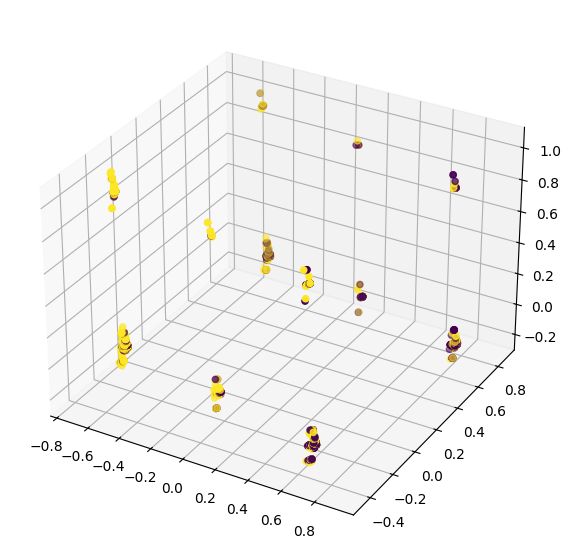

In [17]:
#3 principal components
pca = PCA(n_components=3).fit(x_train)
pca_feats = pca.transform(x_train)

# print(pca.components_)
fig = plt.figure(figsize=(7,7))
axis=fig.add_subplot(111,projection='3d')
axis.scatter(pca_feats[:,0],pca_feats[:,1],pca_feats[:,2],\
             c=y_train);

print('Variance Ratio By Component: ', pca.explained_variance_ratio_)

Variance Ratio By Component:  [0.48311577 0.18221613]


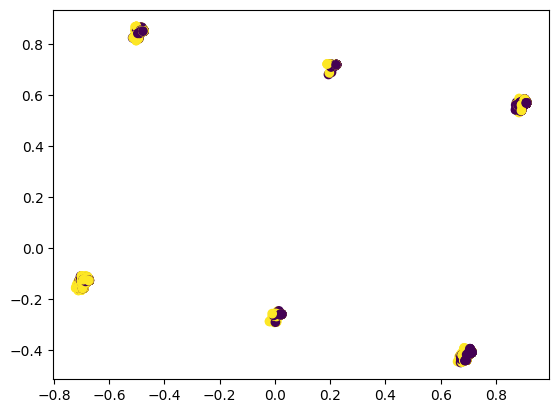

In [18]:
#2 principal components
pca = PCA(n_components=2).fit(x_train)
pca_feats = pca.transform(x_train)

plt.scatter(pca_feats[:,0],pca_feats[:,1], c=y_train);

print('Variance Ratio By Component: ', pca.explained_variance_ratio_)

#### Modeling using PCA

In [ ]:
pca_val_x = pca.transform(x_val)

log_model = LogisticRegression(solver='liblinear',max_iter = 1000).fit(pca_feats,y_train)
forest_model = RandomForestClassifier(n_estimators=100,random_state=42).fit(pca_feats,y_train)
linear_model = LinearSVC(random_state = 42).fit(pca_feats,y_train)

log_score = log_model.score(pca_val_x,y_val)
forest_score = forest_model.score(pca_val_x,y_val)
linear_score = linear_model.score(pca_val_x,y_val)

print(log_score,forest_score, linear_score)

_The above results are very interesting, but I suppose not surprising. The PCA revealed little in the way of a definitive hyperplane among the input features._

#### Grid Search CV

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
#normalization of training data
x_train=(x_train-np.min(x_train))/(np.max(x_train)-np.min(x_train))

##### Logistic Regression Model

In [150]:
# log_grid={"C":np.logspace(-3,3,7), #"penalty":["l1","l2"],
#       "solver":["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
#      # "max_iter":np.linspace(100,10000,4,dtype='int'),
#      "fit_intercept":[True,False]}

# logreg=LogisticRegression()
# logreg_cv=GridSearchCV(logreg,log_grid,cv=10)
# logreg_cv.fit(x_train,y_train)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

##### Random Forest Model

In [23]:
# ### Cell takes forever to run, only run if you have 20 extra min
# forest_grid ={
#     "n_estimators":np.linspace(10,1000,10,dtype='int'),
#     "criterion":["gini","entropy","log_loss"],
#     "max_features":["sqrt","log2"]
# }

# forest = RandomForestClassifier()
# forest_cv = GridSearchCV(forest,forest_grid,cv=10)
# forest_cv.fit(x_train,y_train)

# print("tuned hpyerparameters :(best parameters) ",forest_cv.best_params_)
# print("accuracy :",forest_cv.best_score_)

### Additional Model Examination

In [24]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [123]:
train_and_val = pd.read_csv('train.csv')
train, val = train_test_split(train_and_val,test_size=0.3,random_state=42)

x_train, y_train = tweet_processing(train)

x_val, y_val = tweet_processing(val)

#### Gaussian Naive Bayes

In [135]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train,y_train).predict(x_val)

print("Number of mislabeled points out of a total %d points : %d"
      % (x_val.shape[0], (y_val != y_pred).sum()))
print("Accuracy: ", ((y_val == y_pred).sum() / x_val.shape[0])) 

Number of mislabeled points out of a total 2284 points : 747
Accuracy:  0.6729422066549913


#### Bernoulli Naive Bayes

In [125]:
bnb = BernoulliNB()
y_pred = bnb.fit(x_train,y_train).predict(x_val)
print("Number of mislabeled points out of a total %d points : %d"
      % (x_test.shape[0], (y_val != y_pred).sum()))
print("Accuracy: ", ((y_test == y_pred).sum() / x_val.shape[0])) 

Number of mislabeled points out of a total 3263 points : 825
Accuracy:  0.48555166374781084


#### Deep Learning Model

In [156]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [159]:
input_shape = [x_train.shape[1]]

def create_base_model():
    keras_model = keras.Sequential([
        layers.Dense(512,activation='relu',input_shape=input_shape),
        layers.Dense(1,activation='sigmoid')
        ])
    
    keras_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
        )
    return keras_model

estimator = KerasClassifier(model=create_base_model,epochs=200,batch_size=50,verbose=0)
kfold = StratifiedKFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/home/ljones333/miniconda3/envs/chem277b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ljones333/miniconda3/envs/chem277b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ljones333/miniconda3/envs/chem277b/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

Baseline: 67.09% (1.99%)


#### Outputting Predictions

In [149]:
output_model  = GaussianNB()
#output_model = LogisticRegression(solver='sag',max_iter = 1000).fit(x_train,y_train)
ids = final_test['id']
y_pred = (pd.DataFrame(output_model.fit(x_train,y_train).predict(x_test))
          .rename(columns={0:'target'})
        )

y_pred.insert(0,'id',value=ids)
display(y_pred.head())
y_pred.to_csv('submission_3.csv',index=False)

,id,target
0,0,1
1,2,1
2,3,0
3,9,1
4,11,0
